In [48]:
# Importing required libraries

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV


# Import the CSV file into a DataFrame
df= pd.read_csv('preprocessed_data.csv')

# Display the first few rows of the imported DataFrame
df.head()


,Longitude,Latitude,Cloud_Cover_Percentage,Diurnal_Temp_Range,Frost_Days,Evapotranspiration,Precipitation_Amount,Mean_Temp,Vapor_Pressure,Wet_Days_Count,elevation,Buffalo_Population,Cattle_Population,lumpy
0,90.380931,22.437184,41.6,12.8,0.00,2.3,1.7,19.1,15.7,0.000000,147,27970.983100,3691.746950,1
1,87.854975,22.986757,40.5,13.3,0.00,2.4,0.0,19.8,16.3,0.000000,145,25063.646690,671.326701,1
2,85.279935,23.610181,27.3,13.6,0.08,2.3,0.6,16.2,13.0,0.520635,158,6038.477155,1426.839831,1
3,81.564510,43.882221,45.3,12.8,31.00,0.4,8.8,-16.1,0.9,1.004259,178,760.703340,0.000000,1
4,81.161057,43.834976,38.8,13.2,31.00,0.4,10.5,-13.8,1.2,0.687904,185,270.367426,0.000000,1


In [49]:
# Drop the specified columns from the DataFrame
df = df.drop(columns=['Longitude', 'Latitude'])


In [50]:
# step1: Define features and target variable

X = df.drop(["lumpy"], axis=1)
y = df["lumpy"]

# Step 2: Handling imbalanced data with SMOTE (oversampling the minority class)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [51]:
# Step 3: Splitting the resampled data into train (60%), validation (20%), and test (20%) sets

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4,random_state=42, stratify=y_resampled) # 60% training

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,random_state=42, stratify=y_temp) # 20% validation, 20% testing

In [52]:
    # Step 4: Feature Selection using SelectKBest (ANOVA F-test)
    # Select the top 3 features (you can adjust k to any number)
    feature_selector = SelectKBest(score_func=f_classif, k=3)
    X_train_selected = feature_selector.fit_transform(X_train, y_train)
    X_val_selected = feature_selector.transform(X_val)
    X_test_selected = feature_selector.transform(X_test)

In [53]:
# Get the names of the selected features
selected_features = X.columns[feature_selector.get_support()]
print(selected_features)

Index(['Cloud_Cover_Percentage', 'Precipitation_Amount', 'Mean_Temp'], dtype='object')


In [54]:
# Step 5: Scaling Features 
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_val_selected = scaler.transform(X_val_selected)
X_test_selected = scaler.transform(X_test_selected)

In [55]:
# Step 6: Hyperparameter Tuning with GridSearchCV
# Random Forest Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=3, n_jobs=-1, verbose=2)
rf_grid.fit(X_train_selected, y_train)
best_rf_model = rf_grid.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [56]:
# XGBoost Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=3, n_jobs=-1, verbose=2)
xgb_grid.fit(X_train_selected, y_train)
best_xgb_model = xgb_grid.best_estimator_


Fitting 3 folds for each of 243 candidates, totalling 729 fits


In [57]:
# Step 7: Validate the models
# Random Forest Validation
y_val_pred_rf = best_rf_model.predict(X_val_selected)
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Validation Accuracy: {rf_accuracy}")
print("Random Forest Validation Report:")
print(classification_report(y_val, y_val_pred_rf))


Random Forest Validation Accuracy: 0.9480817826786124
Random Forest Validation Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4353
           1       0.95      0.95      0.95      4353

    accuracy                           0.95      8706
   macro avg       0.95      0.95      0.95      8706
weighted avg       0.95      0.95      0.95      8706



In [58]:
# XGBoost Validation
y_val_pred_xgb = best_xgb_model.predict(X_val_selected)
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
print(f"XGBoost Validation Accuracy: {xgb_accuracy}")
print("XGBoost Validation Report:")
print(classification_report(y_val, y_val_pred_xgb))


XGBoost Validation Accuracy: 0.9499195956811395
XGBoost Validation Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4353
           1       0.95      0.95      0.95      4353

    accuracy                           0.95      8706
   macro avg       0.95      0.95      0.95      8706
weighted avg       0.95      0.95      0.95      8706



In [59]:
# Step 8: Testing the models
# Random Forest Testing
y_test_pred_rf = best_rf_model.predict(X_test_selected)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")
print("Random Forest Test Report:")
print(classification_report(y_test, y_test_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf))

Random Forest Test Accuracy: 0.9518722719963244
Random Forest Test Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4353
           1       0.95      0.95      0.95      4353

    accuracy                           0.95      8706
   macro avg       0.95      0.95      0.95      8706
weighted avg       0.95      0.95      0.95      8706

Random Forest Confusion Matrix:
[[4132  221]
 [ 198 4155]]


In [60]:
# XGBoost Testing
y_test_pred_xgb = best_xgb_model.predict(X_test_selected)
xgb_test_accuracy = accuracy_score(y_test, y_test_pred_xgb)
print(f"XGBoost Test Accuracy: {xgb_test_accuracy}")
print("XGBoost Test Report:")
print(classification_report(y_test, y_test_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_xgb))


XGBoost Test Accuracy: 0.9486560992419021
XGBoost Test Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4353
           1       0.95      0.95      0.95      4353

    accuracy                           0.95      8706
   macro avg       0.95      0.95      0.95      8706
weighted avg       0.95      0.95      0.95      8706

XGBoost Confusion Matrix:
[[4115  238]
 [ 209 4144]]


In [61]:

# Step 9: Comparing the models
print("\nComparison of Models:")
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy}")

if rf_test_accuracy > xgb_test_accuracy:
    print("Random Forest performed better on the test data.")
else:
    print("XGBoost performed better on the test data.")




Comparison of Models:
Random Forest Test Accuracy: 0.9518722719963244
XGBoost Test Accuracy: 0.9486560992419021
Random Forest performed better on the test data.


In [63]:
!pip install seaborn


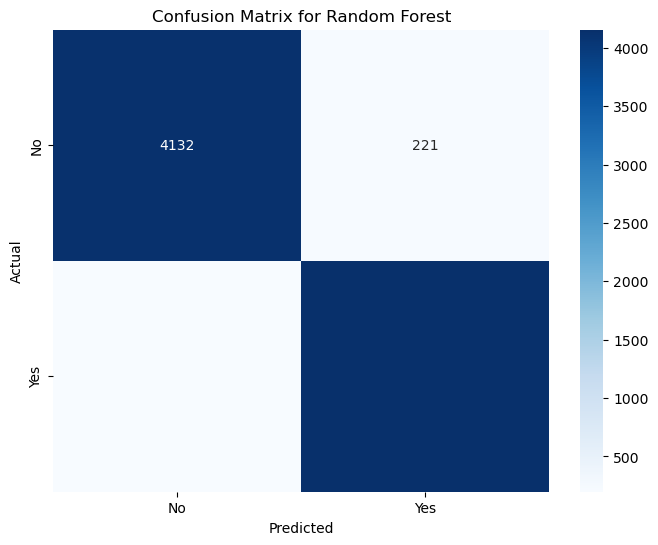

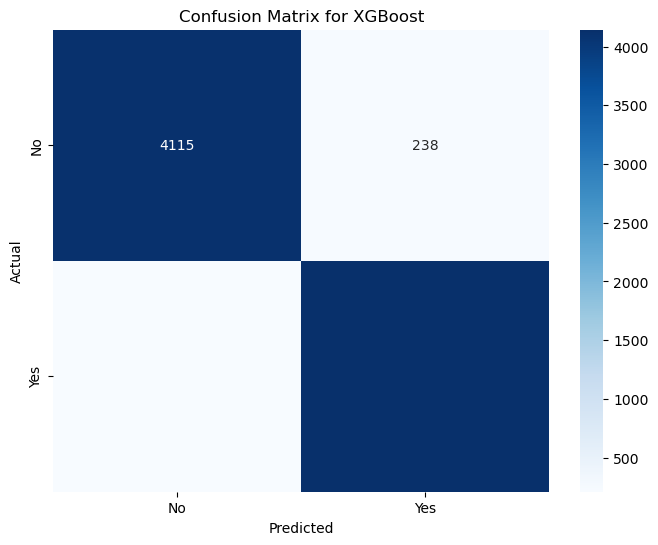

In [65]:
# Step 10: Error Analysis (Optional)
# Analyze misclassifications
rf_confusion = confusion_matrix(y_test, y_test_pred_rf)
xgb_confusion = confusion_matrix(y_test, y_test_pred_xgb)

# Function to plot confusion matrix
import seaborn as sns

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plotting the confusion matrices
plot_confusion_matrix(rf_confusion, 'Random Forest')
plot_confusion_matrix(xgb_confusion, 'XGBoost')

In [70]:
#!pip install seaborn matplotlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

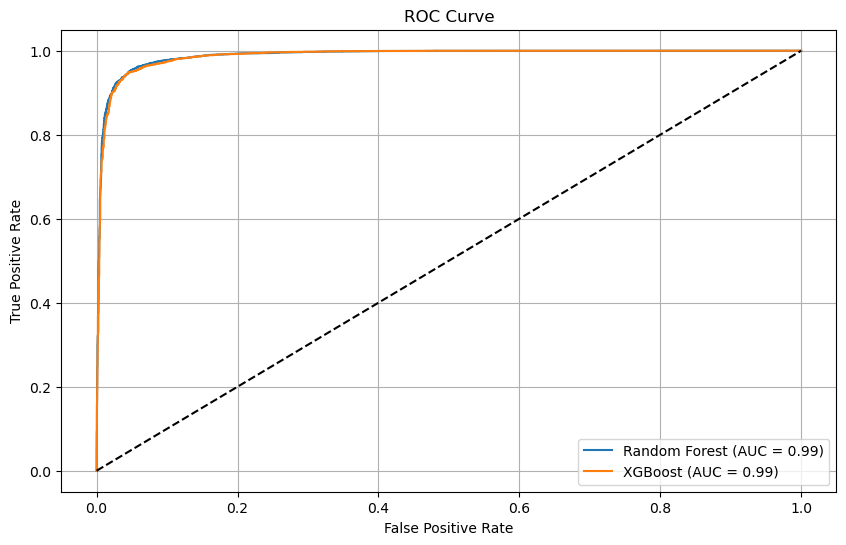

In [71]:
# Step 9: Visualization of ROC Curves
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
# Predict probabilities for ROC
y_test_prob_rf = best_rf_model.predict_proba(X_test_selected)[:, 1]
y_test_prob_xgb = best_xgb_model.predict_proba(X_test_selected)[:, 1]

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, y_test_prob_rf, 'Random Forest')
plot_roc_curve(y_test, y_test_prob_xgb, 'XGBoost')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

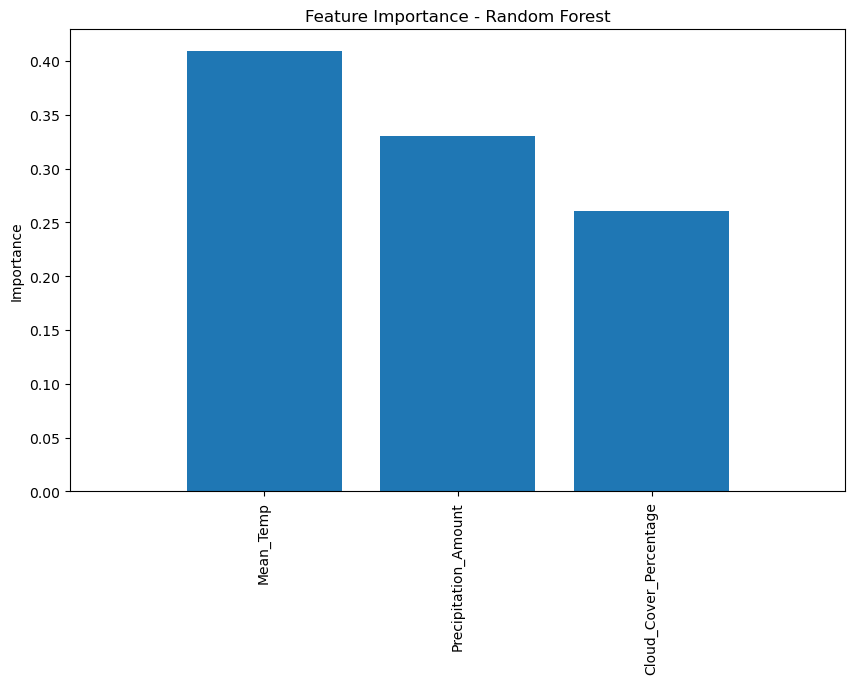

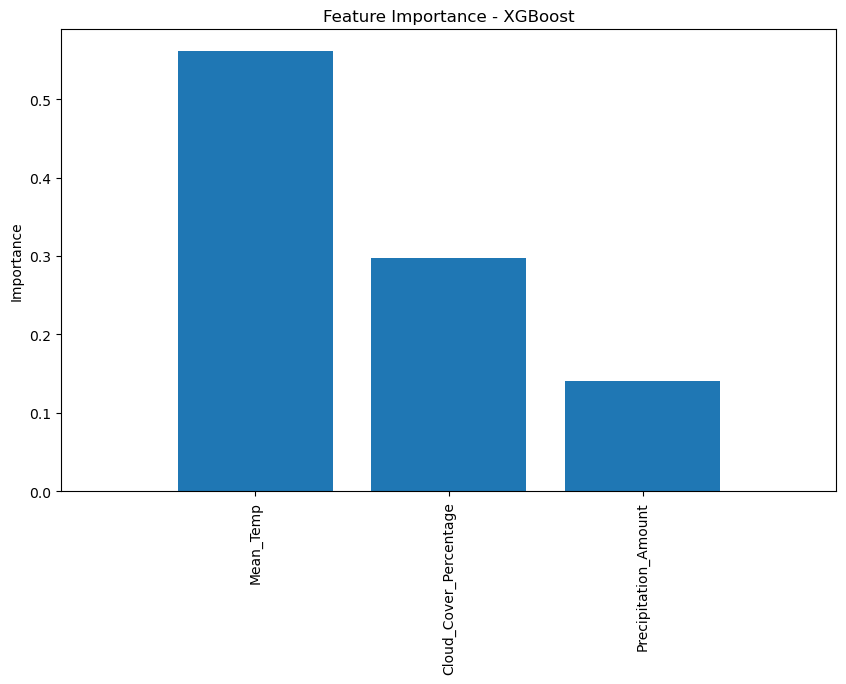

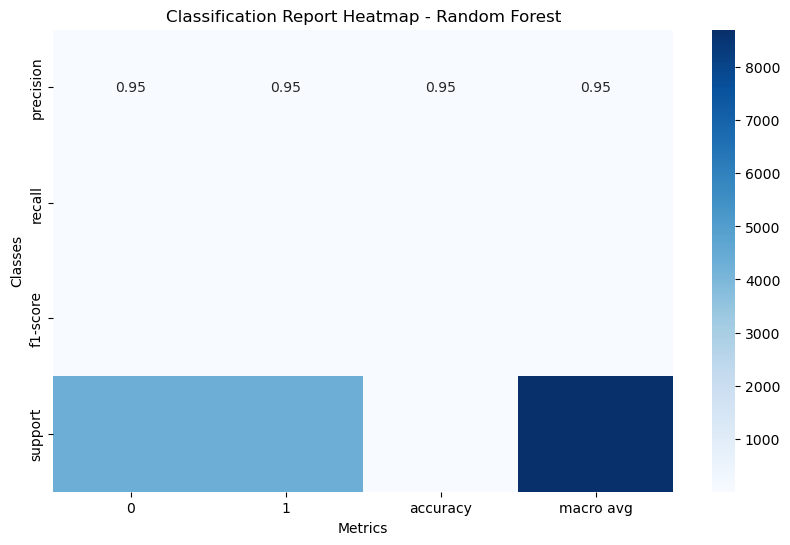

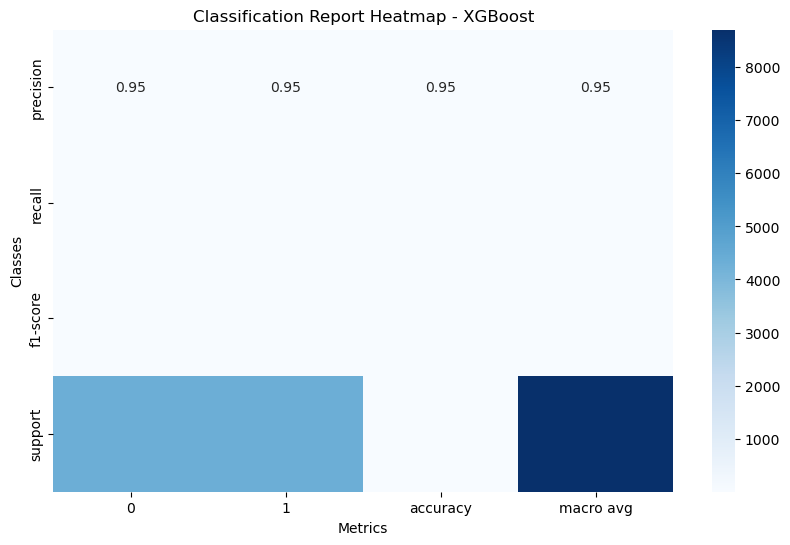

In [72]:

# Step 10: Feature Importance Plot
def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance - {model_name}')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
    plt.xlim([-1, len(indices)])
    plt.ylabel('Importance')
    plt.show()

# Plotting feature importance for both models
plot_feature_importance(best_rf_model, selected_features, 'Random Forest')
plot_feature_importance(best_xgb_model, selected_features, 'XGBoost')

# Step 11: Classification Report as Heatmap
def plot_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title(f'Classification Report Heatmap - {model_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

# Plotting classification reports for both models
plot_classification_report(y_test, y_test_pred_rf, 'Random Forest')
plot_classification_report(y_test, y_test_pred_xgb, 'XGBoost')